# View GCaMP mismatch closed and open loop seesion 1 and 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import pearsonr, spearmanr
from analysis_functions import *
from model_functions import *
import matplotlib.patches as patches
import seaborn as sns

In [2]:
RunTresholdDict = {'B3M1': 145, 'B3M2': 295, 'B3M3': 325, 'B2M4': 110, 'B2M5': 180}

In [ ]:
GCaMP_MM_1 = pd.read_csv('GCaMP_MMclosed_open_session1.csv', dtype=dtype_dict)
GCaMP_MM_2 = pd.read_csv('GCaMP_MMclosed_open_session2.csv', dtype=dtype_dict)

In [ ]:
# Chaning event name to halt and making it so that its True when there is a halt
#GCaMP_MM_1.loc[:, 'event'] = GCaMP_MM_1['event'].replace({False: True, True: False})
GCaMP_MM_1.rename(columns = {'event': 'halt'}, inplace = True)
GCaMP_MM_2.rename(columns = {'event': 'halt'}, inplace = True)


In [ ]:
#Make sure the index provides inforamtion of seconds since start
GCaMP_MM_1.set_index('Seconds', inplace=True)
GCaMP_MM_2.set_index('Seconds', inplace=True)


In [ ]:
#Check that the same mice are in the datsets
print(GCaMP_MM_1.mouseID.unique())
print(GCaMP_MM_2.mouseID.unique())


In [ ]:
## View session data
- Loop through the mouse names present in one of the dataframes (ideally they should be the same)
- save a variable where each session is saved for the current mouse
- use the view_session_mouse() funciton from analysis_functions.py to plot the Delta F/F 470 fluorescence and movement in X direction with halts in grey, and session blocks marked in colors.
- Edit the function to plot different fluorescence traces, movements, and eyes.
- This is mostly to get an impression of the overall data trends.

Plotted traces for B2M5


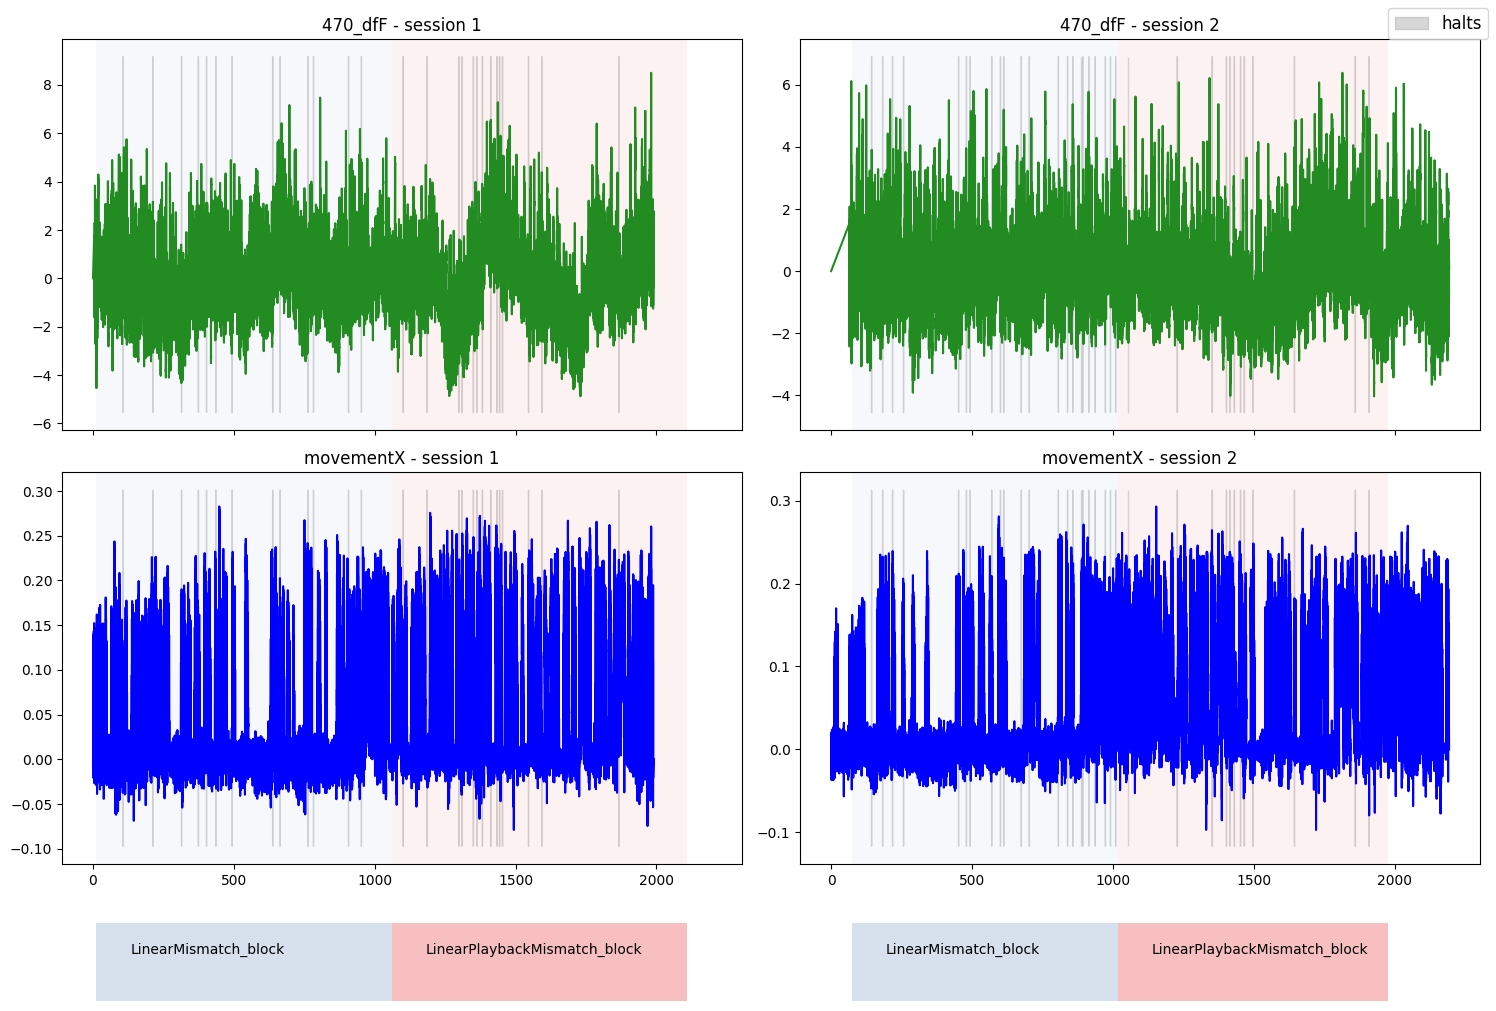

Plotted traces for B2M4


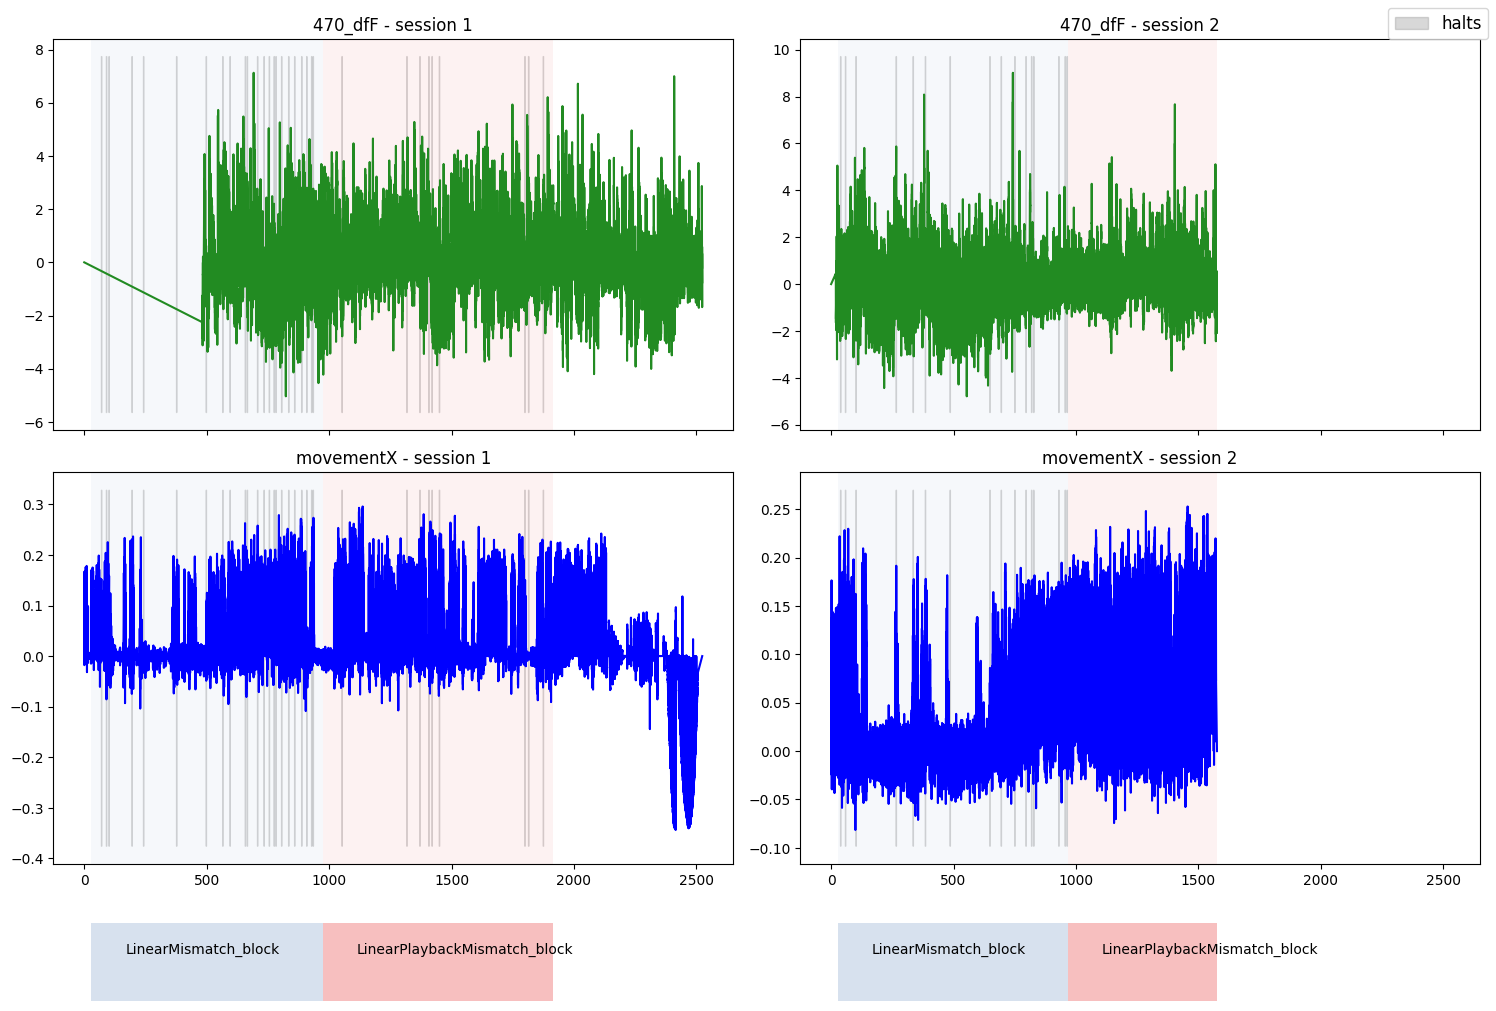

Plotted traces for B3M3


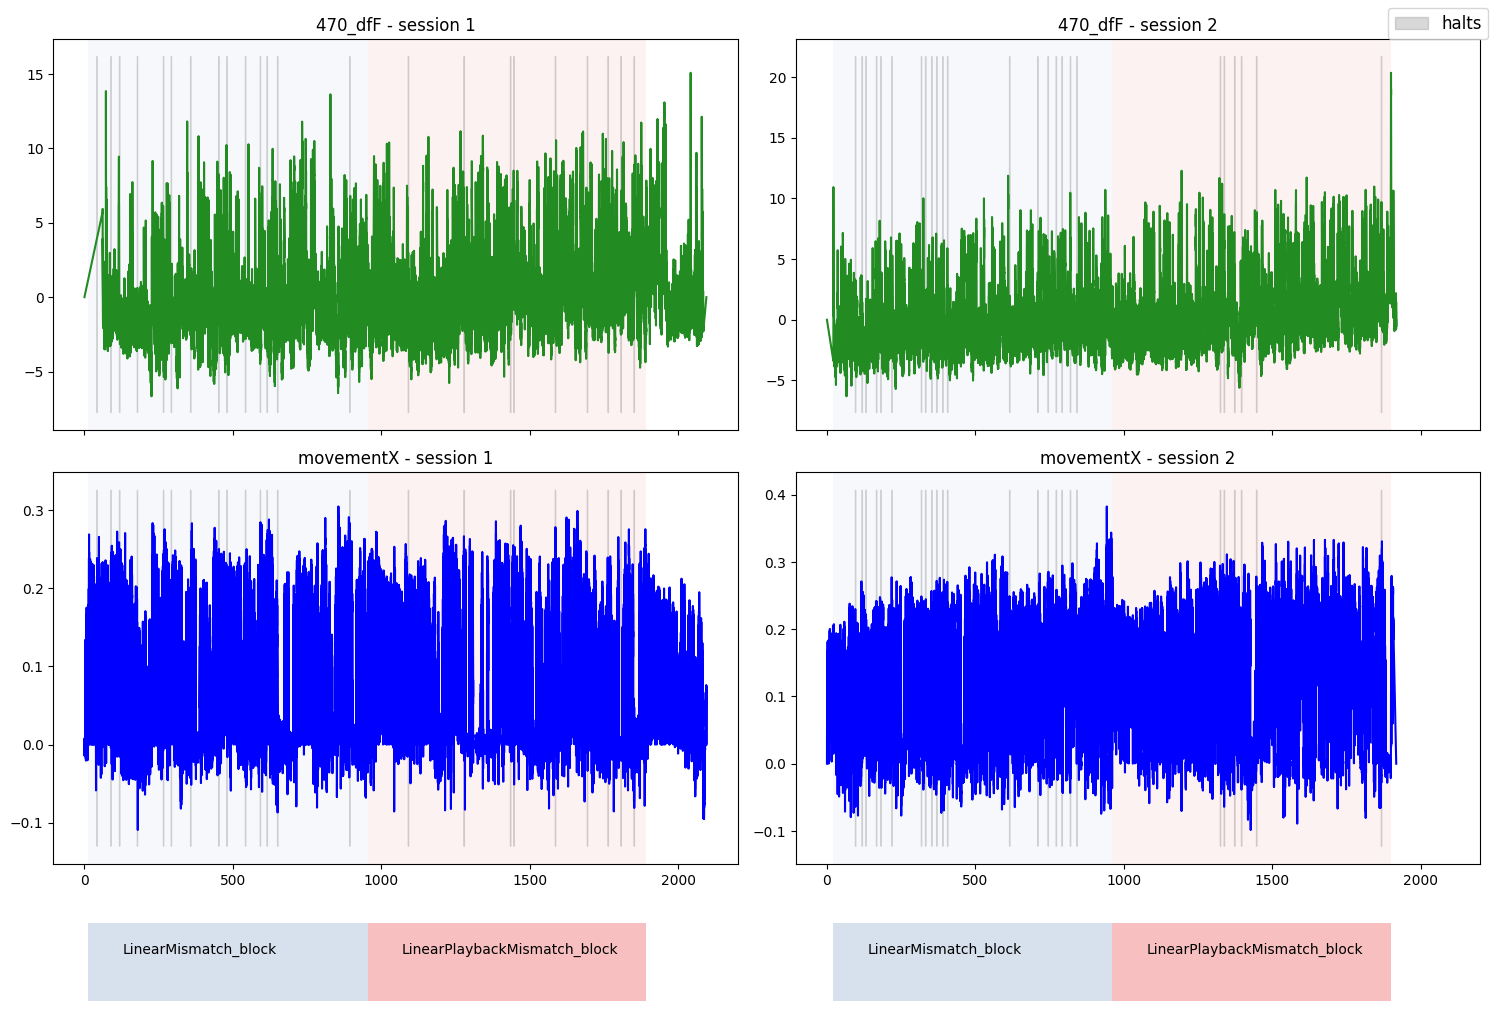

Plotted traces for B3M1


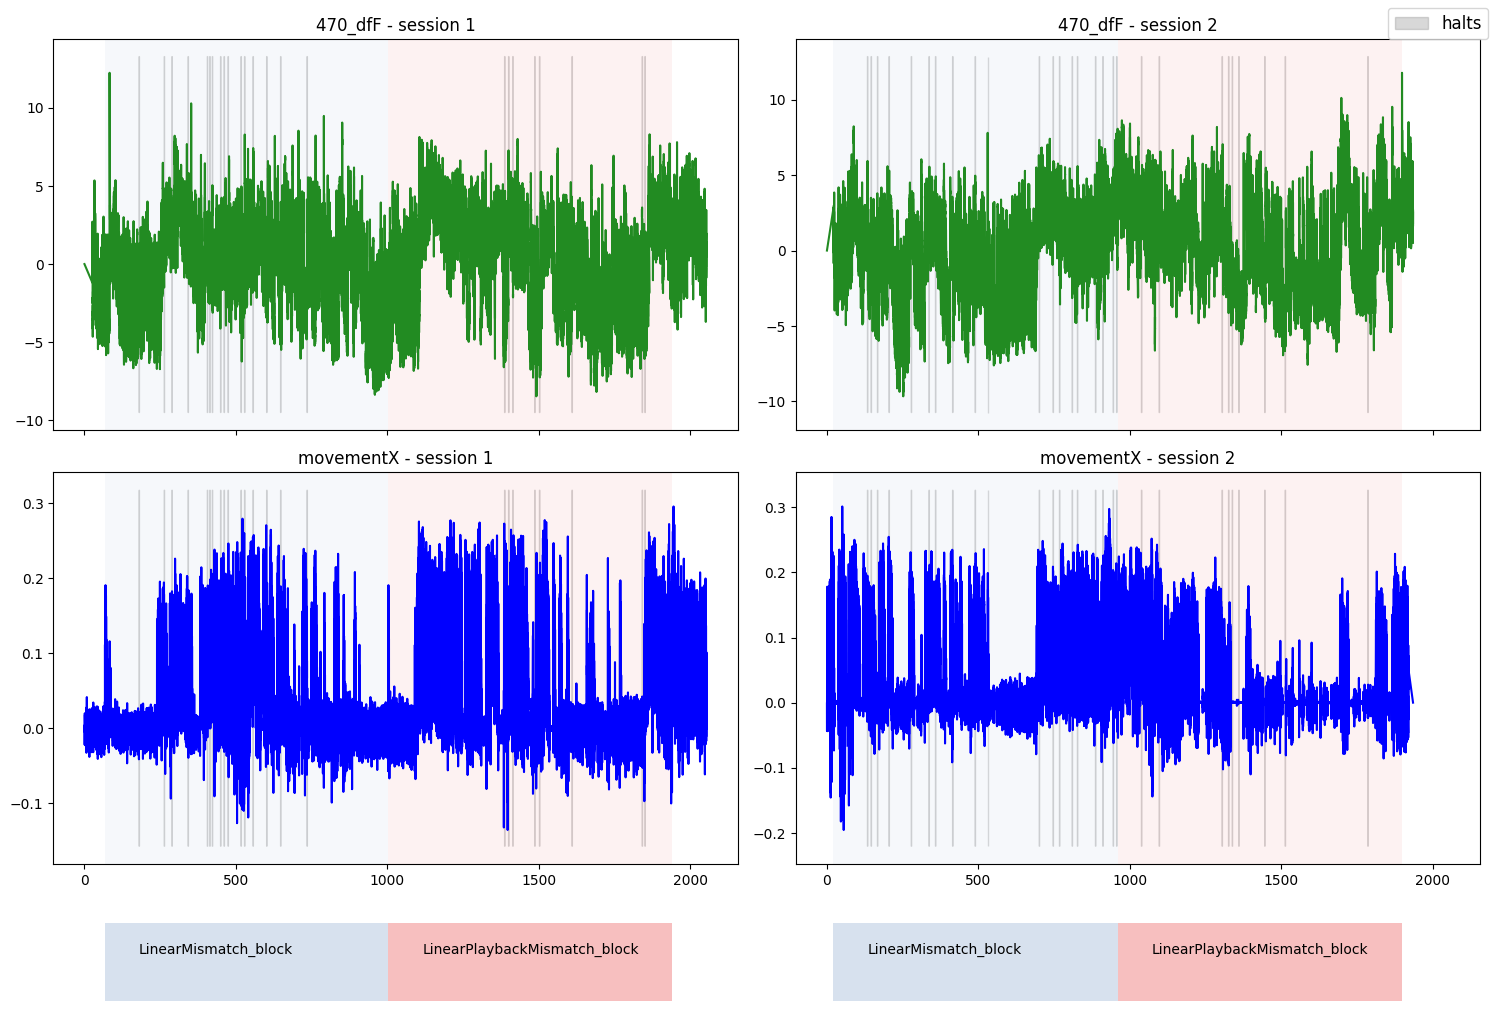

Plotted traces for B3M2


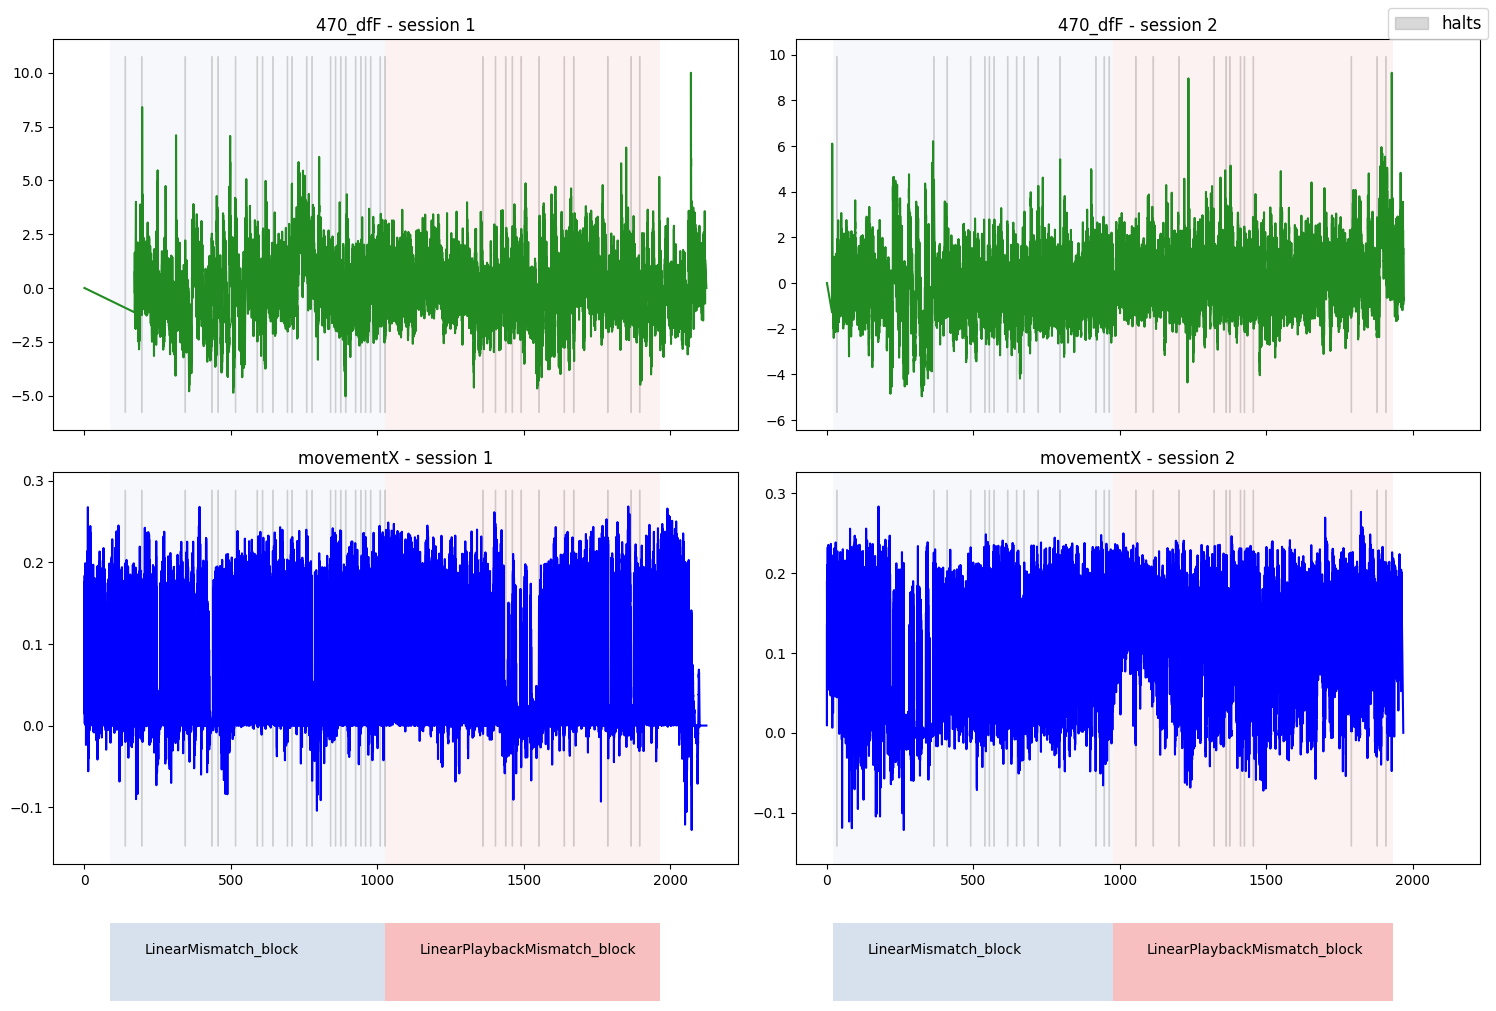

In [7]:
for mouse in GCaMP_MM_1.mouseID.unique():
    mousedata = {'session 1':GCaMP_MM_1.loc[GCaMP_MM_1.mouseID == mouse], 'session 2':GCaMP_MM_2.loc[GCaMP_MM_2.mouseID == mouse]}
    fig, ax =view_session_mouse(mousedata, mouse)
    fig.savefig(f'Figures/GCaMP_{mouse}_view_alignment.png', format = 'png', dpi = 300)

In [8]:
#Filter mice to get unique indexes
mouse_data = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for mouse in GCaMP_MM_1.mouseID.unique():
    mouse_data['session 1']['closedloop'][mouse] = filter_data(GCaMP_MM_1, filters = [mouse, 'closed_block'])
    mouse_data['session 1']['openloop'][mouse] = filter_data(GCaMP_MM_1, filters = [mouse, 'open_block'])
for mouse in GCaMP_MM_2.mouseID.unique():
    mouse_data['session 2']['closedloop'][mouse] = filter_data(GCaMP_MM_2, filters = [mouse, 'closed_block'])
    mouse_data['session 2']['openloop'][mouse] = filter_data(GCaMP_MM_2, filters = [mouse, 'open_block'])

def align_to_event_start(df, trace, event_col, range_around_event):
    
    trace_chunk_list = []
    bsl_trace_chunk_list = []
    run_speed_list = []
    turn_speed_list = []
    event_index_list = []
    
    # Identify the start times for each event
    event_times = df.loc[df[event_col] & ~df[event_col].shift(1, fill_value=False)].index

    # Calculate the time range around each event
    before_0 = range_around_event[0]
    after_0 = range_around_event[1]
    
    # Calculate the target length of each chunk based on the sampling rate
    sampling_rate = 0.001
    target_length = int(((before_0 + after_0) / sampling_rate) + 1)  # Include both ends
    Index= pd.Series(np.linspace(-range_around_event[0], range_around_event[1], target_length)) # common index
    
    for event_time in event_times:
        
        # Determine the time range for each chunk
        start = event_time - before_0
        end = event_time + after_0
        
        # Extract the chunk from the trace column
        chunk = df[trace].loc[start:end]
        runspeed = df['movementX'].loc[start:event_time].mean() #Saving mean run speed up until halt
        turningspeed = df['movementY'].loc[start:event_time].mean() 
        # Normalize the index to start at -before_0
        chunk.index = (chunk.index - chunk.index[0]) - before_0
        # Check if the chunk is shorter than the target length
        if len(chunk) < target_length:
            # Pad the chunk with NaN values at the end to reach the target length
            padding = pd.Series([np.nan] * (target_length - len(chunk)), index=pd.RangeIndex(len(chunk), target_length))
            chunk = pd.concat([chunk, padding])
            chunk.index = Index # Getting the same index as the others
        
        # Baseline the chunk
        baselined_chunk = baseline(chunk)
        
        # Append the chunk and baselined chunk to lists
        trace_chunk_list.append(chunk.values)
        bsl_trace_chunk_list.append(baselined_chunk.values)
        run_speed_list.append(runspeed)
        turn_speed_list.append(turningspeed)
        event_index_list.append(event_time)  # Store the event time for use in final column names
    # Convert lists of arrays to DataFrames
    try:
        trace_chunks = pd.DataFrame(np.column_stack(trace_chunk_list), columns=event_index_list)
        bsl_trace_chunks = pd.DataFrame(np.column_stack(bsl_trace_chunk_list), columns=event_index_list)
        run_speeds = pd.DataFrame(np.column_stack(run_speed_list), columns=event_index_list)
        turn_speeds = pd.DataFrame(np.column_stack(turn_speed_list), columns=event_index_list)
        movement_speeds = pd.concat([run_speeds, turn_speeds])
        
        # Set the index as the common time range index for each chunk
        trace_chunks.index = Index
        bsl_trace_chunks.index = Index
        movement_speeds.index = ['Mean_moveX', 'Mean_moveY'] #set X and Y movement as movement speed index
        
        return trace_chunks, bsl_trace_chunks, movement_speeds
    
    except ValueError:
        if len(event_times) < 1:
            print('could not align to events because there were none, will return nothing')
            
        return 0, 0, 0


In [9]:
#Aligning open and closed loop block data to halt start times
mouse_aligned = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}
move_speeds = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

#Using the aling_to_event_start function, make sure that the sampling rate = 0.001, otherwise, change the sampling_rate variable in the function
for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged, run_speeds = align_to_event_start(df, '470_dfF', 'halt',[1,2])
            mouse_aligned[session][block][mouse]  = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt
            move_speeds[session][block][mouse]  = run_speeds
    

In [10]:
move_speeds['session 1']['closedloop']['B3M1']

180.608   263.674   288.957   342.440   405.889   414.039  \
Mean_moveX -0.000278  0.073069  0.077854  0.106146  0.103029  0.111999   
Mean_moveY  0.000026  0.010887  0.008196  0.009504  0.013565  0.011434   

             422.422   449.539   461.355   474.455   517.172   528.805  \
Mean_moveX  0.130860  0.076662  0.031469  0.090722  0.090128  0.065463   
Mean_moveY  0.020035  0.011443  0.002663  0.012203  0.010859  0.004414   

             556.904   601.737   647.754   735.203  
Mean_moveX  0.120229  0.088501  0.099724  0.040955  
Mean_moveY  0.018207  0.013311  0.013727  0.007291

In [11]:

mouse_aligned['session 1']['closedloop']['B3M1']

180.608   263.674   288.957   342.440   405.889   414.039   422.422  \
-1.000  0.893200  0.808759 -1.485006  1.370412  0.486514 -1.751622 -1.684634   
-0.999  0.917065  0.796918 -1.467912  1.375058  0.498265 -1.762238 -1.696445   
-0.998  0.940930  0.785077 -1.450818  1.379703  0.510015 -1.774990 -1.708256   
-0.997  0.964795  0.773235 -1.433724  1.384348  0.521765 -1.787743 -1.720067   
-0.996  0.988660  0.761394 -1.416630  1.388994  0.533515 -1.800495 -1.731878   
...          ...       ...       ...       ...       ...       ...       ...   
 1.996 -0.556046  0.085358 -0.864037  0.477381  1.350259  0.145856 -2.079544   
 1.997 -0.550459  0.058852 -0.871840  0.492836  1.344187  0.130554 -2.078087   
 1.998 -0.544872  0.032346 -0.879643  0.508290  1.338114  0.115744 -2.076630   
 1.999 -0.539285  0.005839 -0.887446  0.523745  1.332042  0.102150 -2.075172   
 2.000 -0.533699 -0.020667 -0.895249  0.539199  1.325969  0.088608 -2.073715   

         449.539   461.355   474.455   517.172   528.805   556.904   601.737  \
-1.000  0.251202  1.532164 -0.730746 -1.249215 -0.415138 -0.153782  0.563218   
-0.999  0.248742  1.526851 -0.698289 -1.245754 -0.403388 -0.173456  0.576911   
-0.998  0.246283  1.521537 -0.665832 -1.242292 -0.391638 -0.193131  0.590605   
-0.997  0.243824  1.516224 -0.633760 -1.238831 -0.379888 -0.212806  0.604298   
-0.996  0.241364  1.510910 -0.610572 -1.235370 -0.368137 -0.232481  0.617991   
...          ...       ...       ...       ...       ...       ...       ...   
 1.996  1.239885  1.496127 -3.023576 -2.678555  2.090875 -2.334491  0.477245   
 1.997  1.226100  1.493121 -3.054000 -2.732418  2.108364 -2.337588  0.449615   
 1.998  1.212316  1.490115 -3.084423 -2.786281  2.125853 -2.340685  0.421985   
 1.999  1.198531  1.487109 -3.114846 -2.840144  2.143341 -2.343782  0.394356   
 2.000  1.184747  1.484104 -3.145269 -2.894007  2.160830 -2.346879  0.366726   

         647.754   735.203  
-1.000 -0.337895 -4.848640  
-0.999 -0.342929 -4.828175  
-0.998 -0.326968 -4.807711  
-0.997 -0.306807 -4.787247  
-0.996 -0.286646 -4.766783  
...          ...       ...  
 1.996 -1.537369 -2.941427  
 1.997 -1.542440 -2.960222  
 1.998 -1.547510 -2.979016  
 1.999 -1.557316 -2.997810  
 2.000 -1.578791 -3.016605  

[3001 rows x 16 columns]

In [12]:
len(mouse_aligned['session 1']['closedloop'].keys())

5

In [13]:
mouse_aligned_nohalt = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}
move_speeds_nohalt = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}
for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged, run_speeds = align_to_event_start(df, '470_dfF', 'No_halt',[1,2])
            mouse_aligned_nohalt[session][block][mouse] = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt
            move_speeds_nohalt[session][block][mouse]  = run_speeds

 Session 1 


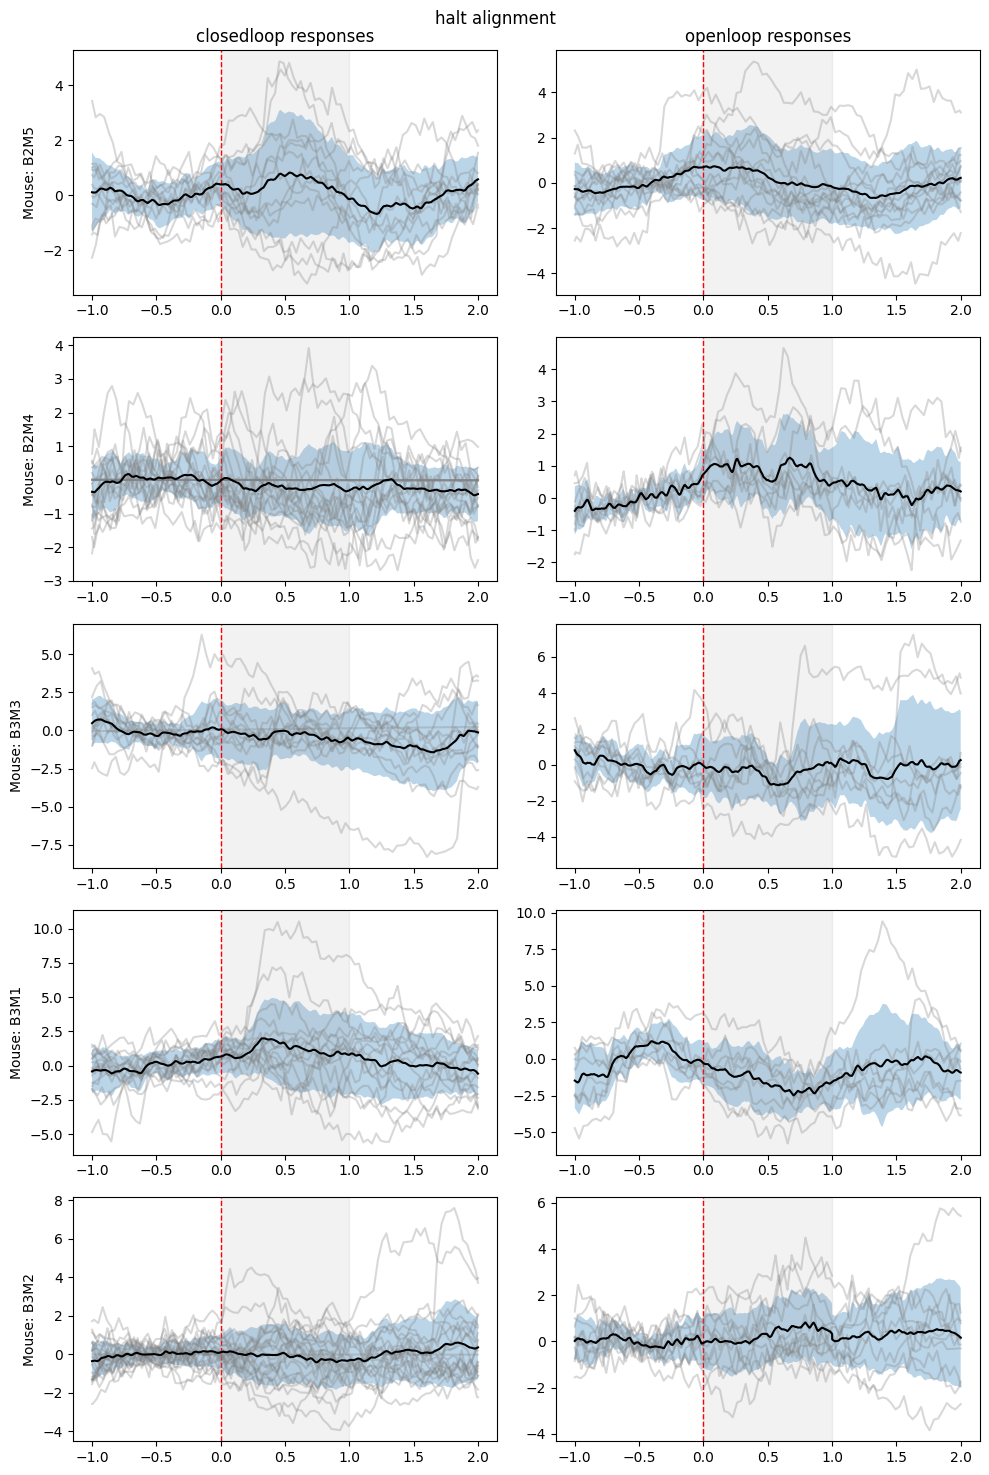

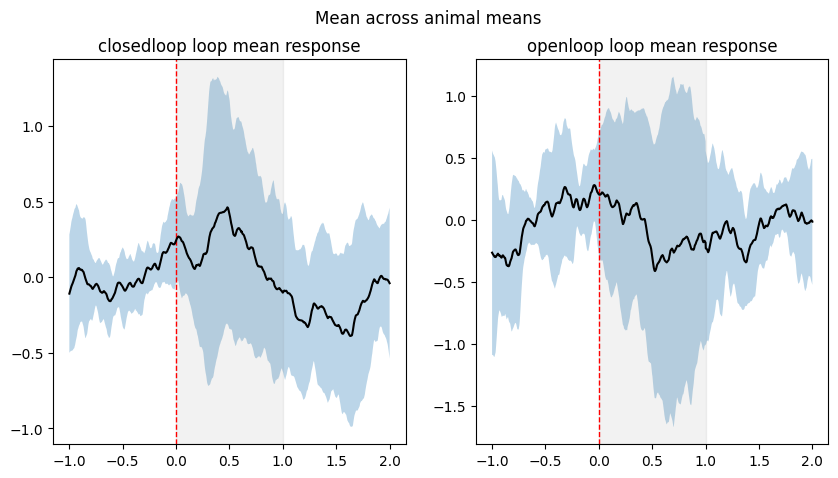

In [14]:
print('\033[1m Session 1 \033[0m')
mean_mouse_dict_s1 =plot_compare_blocks(mouse_aligned['session 1'], 'halt')


 Session 2 


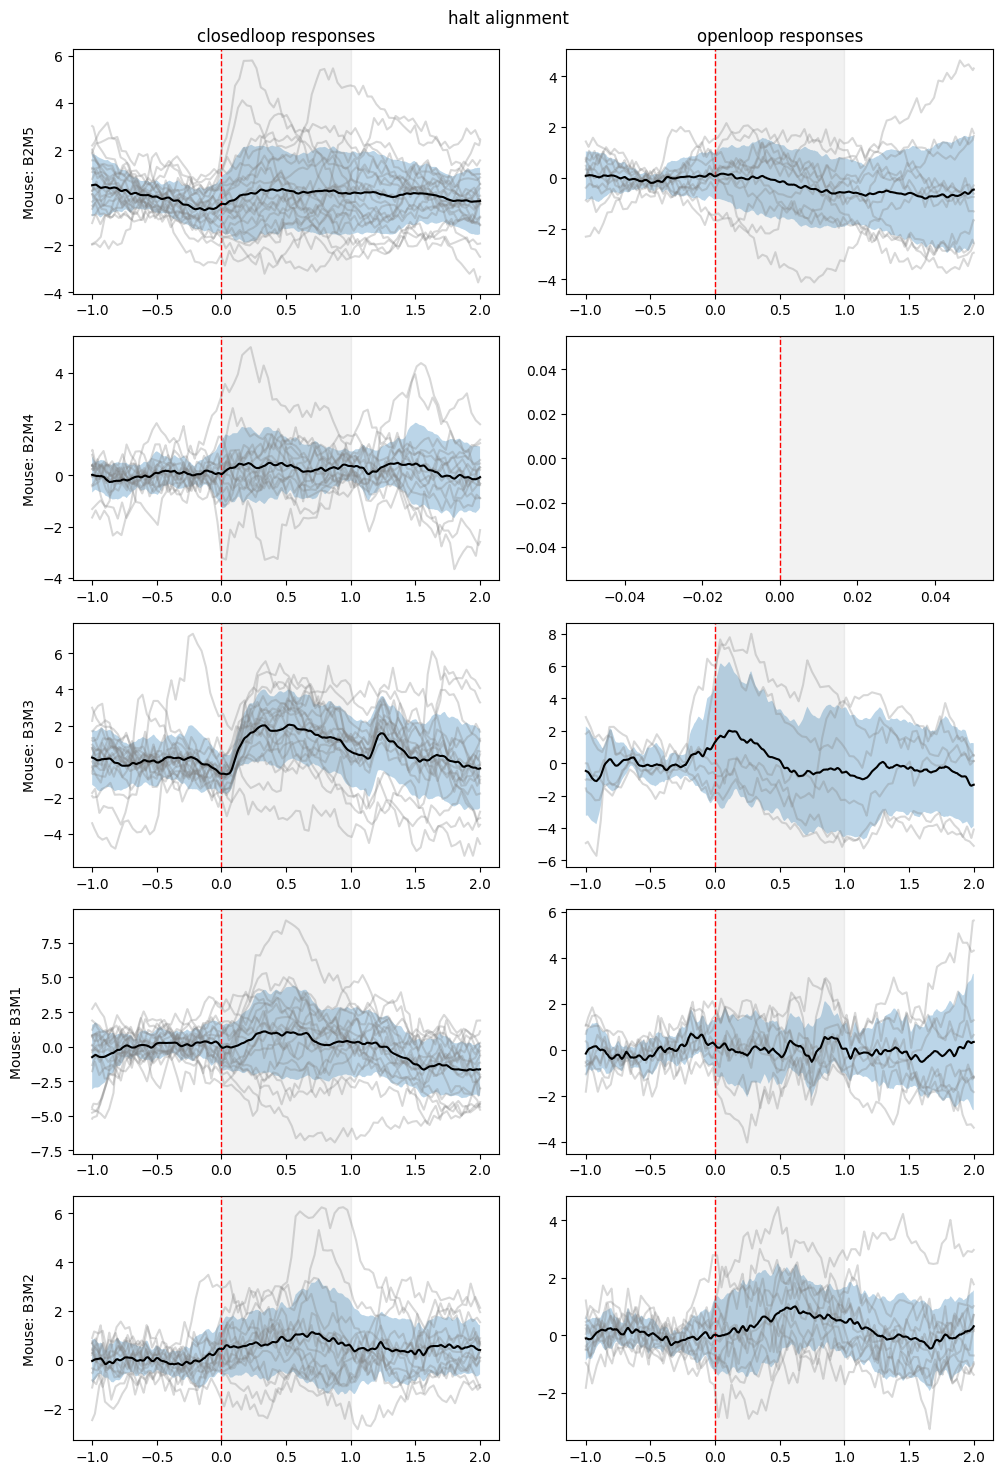

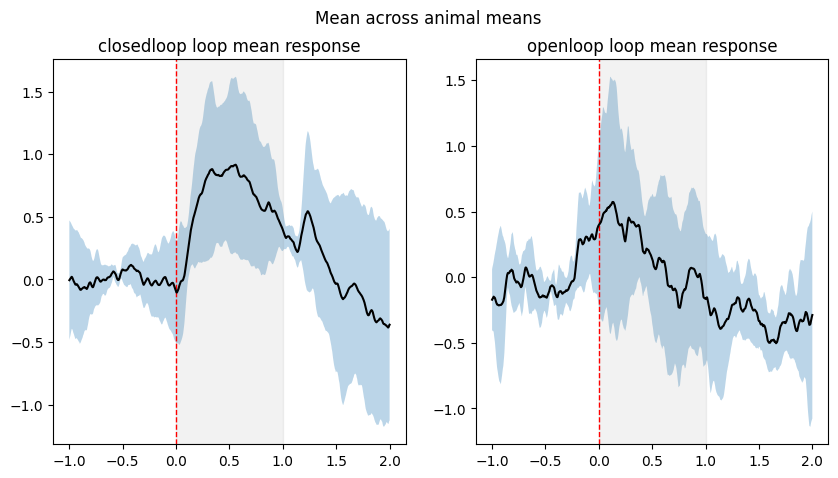

In [15]:
print('\033[1m Session 2 \033[0m')
mean_mouse_dict_s2 =plot_compare_blocks(mouse_aligned['session 2'], 'halt')

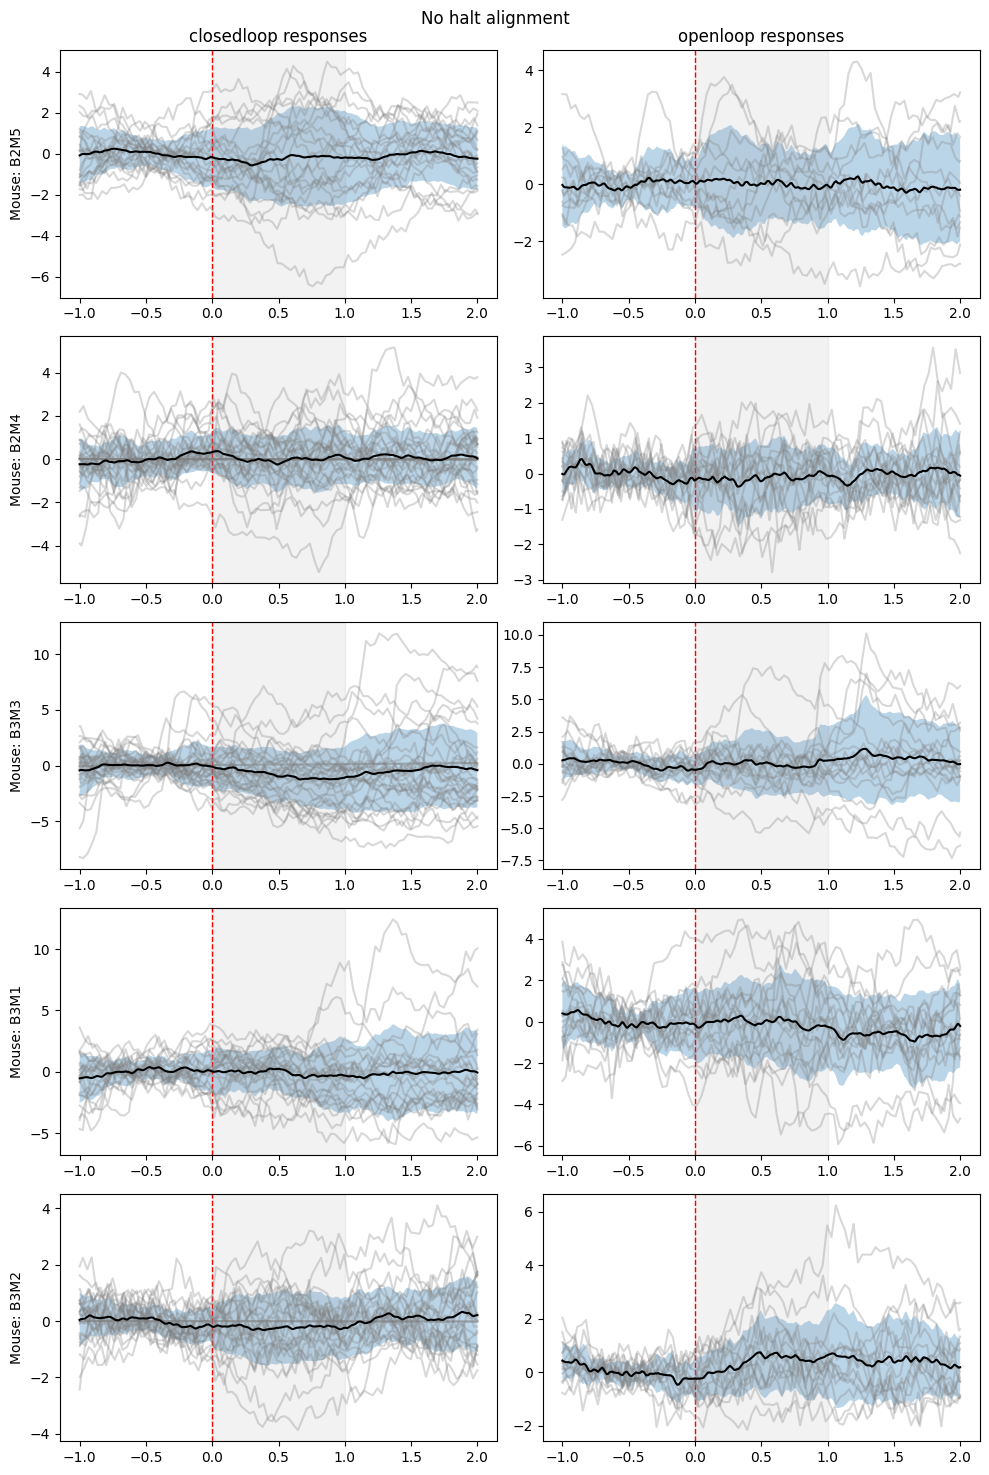

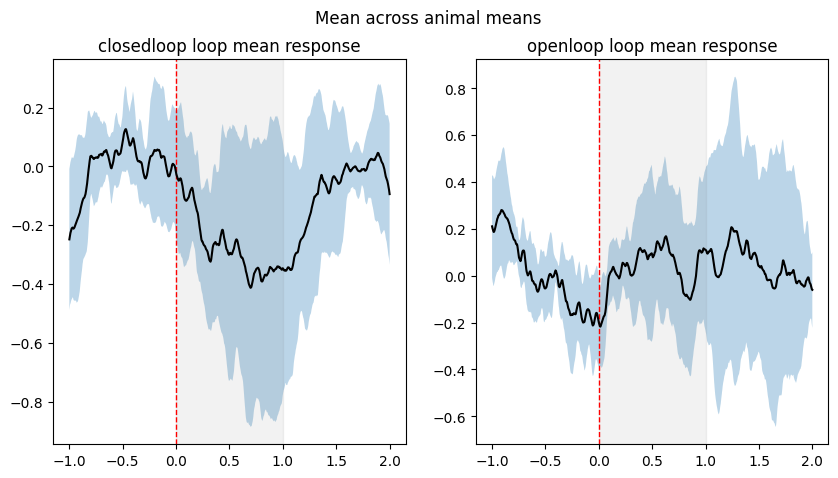

In [16]:
mean_mouse_dict_s1_nohalt =plot_compare_blocks(mouse_aligned_nohalt['session 1'], 'No halt')

In [65]:
mouse_aligned['session 1']['openloop']['B2M5']

1100.480  1185.363  1298.578  1309.728  1349.761  1362.278  1381.844  \
-1.000 -1.114856 -0.622321 -0.464965  0.374119 -0.138063 -0.160669 -2.553432   
-0.999 -1.100718 -0.630599 -0.481129  0.377582 -0.146796 -0.158922 -2.539302   
-0.998 -1.087991 -0.638878 -0.497293  0.368237 -0.155530 -0.157176 -2.525171   
-0.997 -1.092432 -0.647157 -0.513457  0.356330 -0.164263 -0.155430 -2.511040   
-0.996 -1.101811 -0.655435 -0.529621  0.344424 -0.172996 -0.153684 -2.496909   
...          ...       ...       ...       ...       ...       ...       ...   
 1.996  0.653189 -0.446511  1.537022  0.948993  1.233696  0.061365 -2.290632   
 1.997  0.664841 -0.439314  1.538497  0.953948  1.232490  0.067285 -2.272732   
 1.998  0.676494 -0.432117  1.539972  0.958903  1.231283  0.073206 -2.254831   
 1.999  0.688147 -0.424919  1.541447  0.963859  1.230077  0.079126 -2.236931   
 2.000  0.699800 -0.417722  1.542923  0.968814  1.228870  0.085046 -2.219031   

        1411.611  1433.411  1442.811  1453.161  1545.460  1592.976  1866.241  
-1.000  2.314891 -0.269840  0.494715  1.294928 -1.018463 -1.395530 -0.616173  
-0.999  2.304861 -0.271919  0.495122  1.312139 -1.005685 -1.393436 -0.623025  
-0.998  2.294831 -0.273999  0.495530  1.329351 -0.992907 -1.391342 -0.622558  
-0.997  2.284801 -0.276078  0.493978  1.346562 -0.980129 -1.389248 -0.609283  
-0.996  2.274771 -0.278158  0.490822  1.363774 -0.967350 -1.387154 -0.595804  
...          ...       ...       ...       ...       ...       ...       ...  
 1.996  0.048987  0.134199 -0.750893  3.151216 -0.766577  0.705119 -1.238105  
 1.997  0.049527  0.137024 -0.756938  3.141577 -0.770618  0.715233 -1.250969  
 1.998  0.050068  0.139848 -0.762984  3.131938 -0.774659  0.723899 -1.263832  
 1.999  0.050608  0.142673 -0.769029  3.122298 -0.778701  0.732565 -1.276695  
 2.000  0.051148  0.144589 -0.775075  3.112659 -0.782742  0.741230 -1.289558  

[3001 rows x 14 columns]

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mouse_sessions(
    mouse_aligned,
    mouse_aligned_nohalt,
    block_names,
    title="Mouse Sessions",
    stimulus_duration=1,
):
    """
    Plot session-specific traces for each mouse with control data.

    Parameters:
    - mouse_aligned (dict): Dictionary containing session data.
    - mouse_aligned_nohalt (dict): Dictionary containing control data.
    - block_names (list): List of block names (e.g., ['openloop', 'closedloop']) to plot.
    - title (str): Title prefix for each mouse figure.
    - stimulus_duration (float): Duration of the stimulus in seconds (default: 1 second).
    """
    mice = set()
    sessions = mouse_aligned.keys()

    # Collect all mice
    for session in mouse_aligned.values():
        for block in block_names:
            mice.update(session[block].keys())

    for mouse in mice:
        # Create a figure for each mouse
        fig, axes = plt.subplots(1, len(block_names), figsize=(5 * len(block_names), 4))
        axes = np.atleast_1d(axes)  # Ensure axes is iterable
        fig.suptitle(f"{title}: {mouse}")

        for i, block in enumerate(block_names):
            ax = axes[i]
            ax.spines[['right', 'top']].set_visible(False)

            # Plot control data (averaged across sessions)
            control_data = []
            for session in mouse_aligned_nohalt.values():
                if block in session and mouse in session[block]:
                    control_data.append(session[block][mouse])

            if control_data:
                # Ensure all arrays have the same length and use their time index
                valid_control_data = [
                    arr for arr in control_data if arr.shape[0] > 0
                ]
                if valid_control_data:
                    time_index = valid_control_data[0].index
                    control_data_concat = np.concatenate(valid_control_data, axis=1)
                    control_mean = control_data_concat.mean(axis=1)
                    control_std = control_data_concat.std(axis=1)
                    ax.plot(
                        time_index,
                        control_mean,
                        label="Control",
                        color="black",
                    )
                    ax.fill_between(
                        time_index,
                        control_mean - control_std,
                        control_mean + control_std,
                        color="black",
                        alpha=0.1,
                    )

            # Plot main traces for each session
            for session_name, session in mouse_aligned.items():
                if block in session and mouse in session[block]:
                    main_data = session[block][mouse]
                    time_index = main_data.index
                    main_mean = main_data.mean(axis=1)
                    main_std = main_data.std(axis=1)
                    ax.plot(
                        time_index,
                        main_mean,
                        label=f"{session_name}",
                        alpha=0.8,
                    )
                    ax.fill_between(
                        time_index,
                        main_mean - main_std,
                        main_mean + main_std,
                        alpha=0.3,
                    )

            # Shade the stimulus area
            ax.axvline(0, color="grey", linestyle="--")
            ax.axvspan(
                0,
                stimulus_duration,
                color="grey",
                alpha=0.1,
                label="Stimulus",
            )

            ax.set_title(f"{block} Block")
            ax.legend()

        plt.tight_layout()
        plt.show()
        plt.close(fig)  # Clear the figure after displaying it


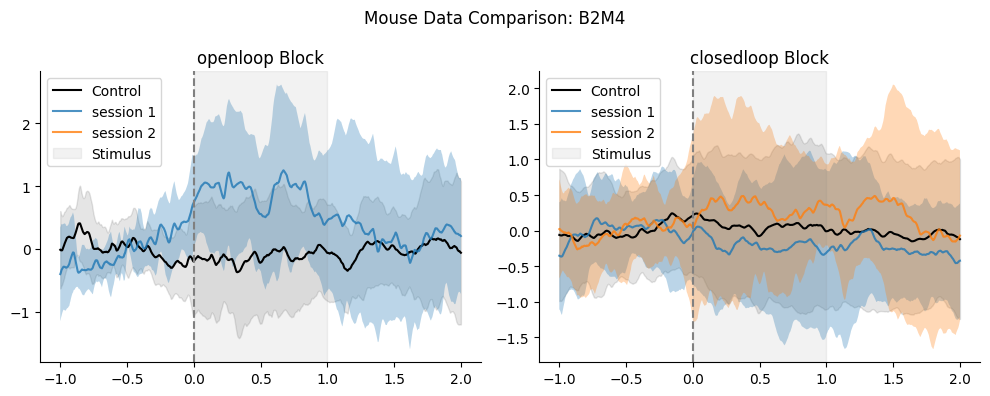

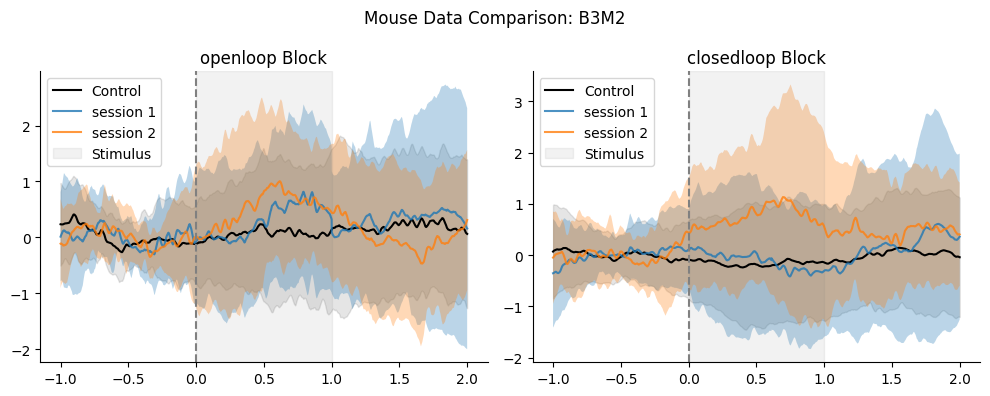

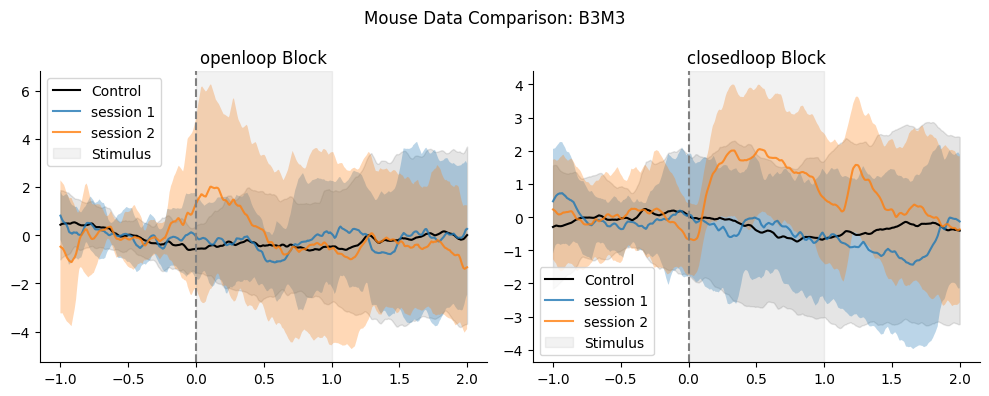

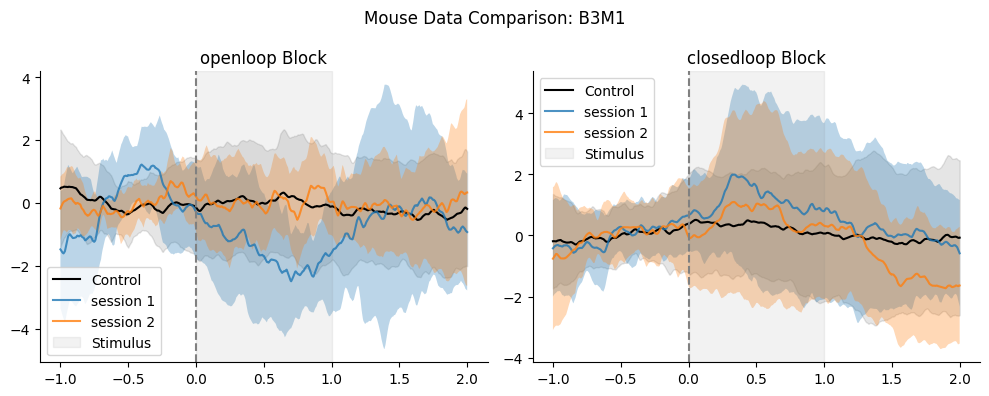

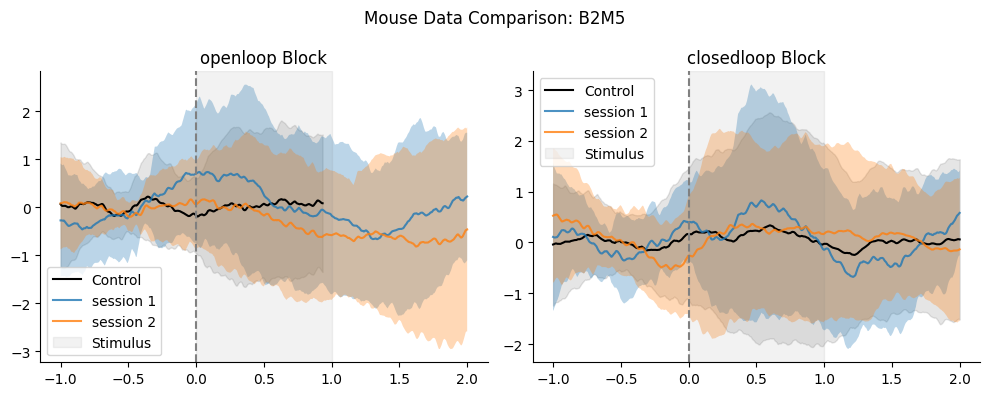

In [69]:
plot_mouse_sessions(
    mouse_aligned,
    mouse_aligned_nohalt,
    block_names=['openloop', 'closedloop'],
    title="Mouse Data Comparison",
    stimulus_duration=1,
)


In [70]:
def plot_mean_across_blocks(session_blocks, control_blocks, title="Mean Across Blocks", stimulus_duration = 1):
    """
    Plot a single figure with the mean across mouse means for each block.
    
    Parameters:
    - session_blocks (dict): Dictionary of session data, where keys are block names
                             and values are dictionaries of mouse data.
    - control_blocks (dict): Dictionary of control data with the same structure.
    - title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.spines[['right', 'top']].set_visible(False)

    for block_name, mouse_data in session_blocks.items():
        if not mouse_data:
            print(f"No data for block: {block_name}")
            continue

        # Compute mean and std across all mice
        block_means = [data.mean(axis=1) for data in mouse_data.values()]
        mean_across_mice = pd.concat(block_means, axis=1).mean(axis=1)
        std_across_mice = pd.concat(block_means, axis=1).std(axis=1)

        # Plot block trace
        ax.plot(mean_across_mice, label=f'{block_name} Mean')
        ax.fill_between(
            mean_across_mice.index,
            mean_across_mice - std_across_mice,
            mean_across_mice + std_across_mice,
            alpha=0.2,
        )

    # Plot control trace
    if control_blocks:
        control_means = [
            data.mean(axis=1) for block_data in control_blocks.values()
            for data in block_data.values()
        ]
        control_mean = pd.concat(control_means, axis=1).mean(axis=1)
        control_std = pd.concat(control_means, axis=1).std(axis=1)

        ax.plot(control_mean, label="Control Mean", color='black', linestyle='--')
        ax.fill_between(
            control_mean.index,
            control_mean - control_std,
            control_mean + control_std,
            color='grey',
            alpha=0.3,
        )

    ax.axvline(0, color='grey', linestyle='--')
    ax.axvspan(0, stimulus_duration, color='grey', alpha=0.1)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()


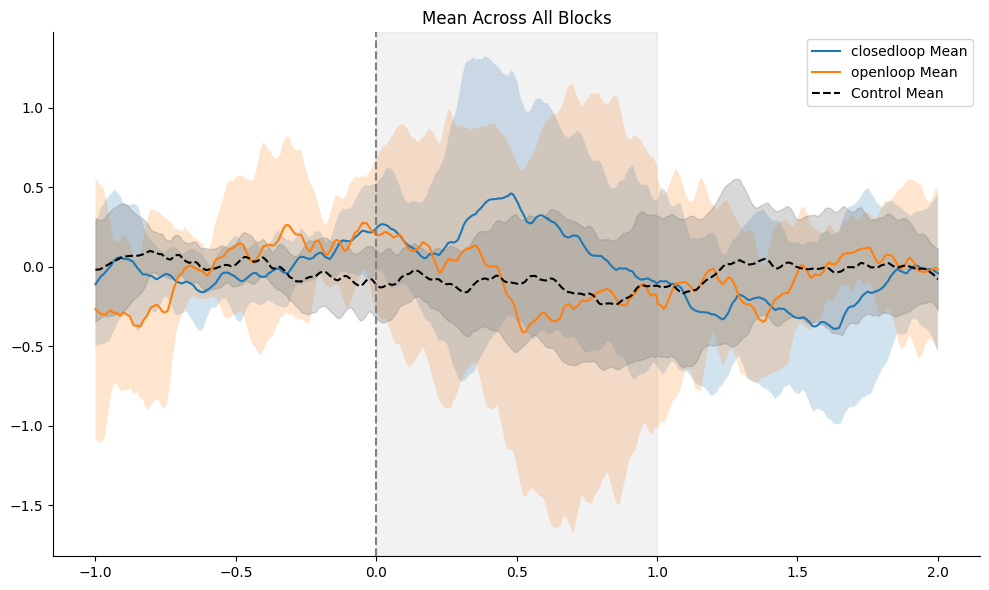

In [71]:
plot_mean_across_blocks(session_blocks, control_blocks, title="Mean Across All Blocks")


In [74]:
sessions = mouse_aligned.keys()


In [75]:
def extract_aligned_vars(aligned_data_dict, aligned_movement_dict):
    # Initialize an empty list to store results
    results = []
    
    for session_number, session_blocks in aligned_data_dict.items():
        for session_block, mice_data in session_blocks.items():
            for mouse_id, item in mice_data.items():
                run_df = aligned_movement_dict[session_number][session_block][mouse_id]
                # Check if the item is a DataFrame
                if not isinstance(item, pd.DataFrame):
                    print(f"Warning: The data for Mouse ID '{mouse_id}' in session '{session_number}' and block '{session_block}' is not a DataFrame. Skipping.")
                    continue

                # Copy the DataFrame and ensure the index is numeric
                df = item.copy()
                df.index = pd.to_numeric(df.index)

                # Process each column independently
                for column in df.columns:
                    event_time_data = df.loc[0:1, column]  # Data during the event (0 to +1 seconds)
                    post_event_data = df.loc[1:2, column]  # Data during the first second after the event (+1 to +2 seconds)

                    peak_response = event_time_data.max()  # Max response during the event
                    min_response = event_time_data.min()  # Minimum response during the event
                    mean_response_event = event_time_data.mean()  # Mean response during the event
                    mean_response_post_event = post_event_data.mean()  # Mean response during the post-event time
                    min_response_post_event = post_event_data.min()  #Minimum response during the post-event time
                    peak_response_post_event = post_event_data.max() #Maximum response during the post-event time

                    #Given Mean_moveX and Y being the row names in the movement df, the 1 second pre halt movement speeds are added
                    x_move = run_df.loc['Mean_moveX', column]
                    y_move = run_df.loc['Mean_moveY', column]
    
                    #add results to list of dicts
                    results.append({
                        "SessionNumber": session_number,
                        "SessionBlock": session_block,
                        "MouseID": mouse_id,
                        "EventTime": column,
                        "moveX": x_move,
                        "moveY": y_move,
                        "PeakResponse": peak_response,
                        "MinResponse":  min_response,
                        "MeanResponse": mean_response_event,
                        "MeanResponse_after": mean_response_post_event,
                        "MinResponse_after": min_response_post_event,
                        "PeakResponse_after": peak_response_post_event
                    })

    # convert to a pandas df
    output_df = pd.DataFrame(results)
    return output_df



In [76]:
extracted_variables = extract_aligned_vars(mouse_aligned, move_speeds)


In [77]:
extracted_variables_nohalt = extract_aligned_vars(mouse_aligned_nohalt, move_speeds_nohalt)


In [78]:
extracted_variables_nohalt['event']='no halt'
extracted_variables['event']='halt'
combined_vars = pd.concat([extracted_variables_nohalt, extracted_variables])

combined_vars.to_csv('GCaAMP_MM_extracted_vars.csv', index=False)

In [79]:
combined_vars

SessionNumber SessionBlock MouseID  EventTime     moveX     moveY  \
0       session 1   closedloop    B2M5     22.023  0.098172  0.009601   
1       session 1   closedloop    B2M5     35.812  0.055712  0.004859   
2       session 1   closedloop    B2M5     68.662  0.082007  0.009702   
3       session 1   closedloop    B2M5     86.762  0.042355  0.001521   
4       session 1   closedloop    B2M5    141.892  0.083473  0.010315   
..            ...          ...     ...        ...       ...       ...   
266     session 2     openloop    B3M2   1425.272  0.117236  0.012613   
267     session 2     openloop    B3M2   1455.689  0.095919  0.011092   
268     session 2     openloop    B3M2   1790.435  0.123360  0.021138   
269     session 2     openloop    B3M2   1878.385  0.063050  0.011725   
270     session 2     openloop    B3M2   1908.318  0.125194  0.019347   

     PeakResponse  MinResponse  MeanResponse  MeanResponse_after  \
0       -0.140394    -1.892380     -0.991913           -0.484926   
1        2.114826    -1.342501      0.690253            0.299560   
2       -0.370019    -6.463050     -4.203406           -3.249223   
3        3.645258     1.714089      2.657278            1.794567   
4        1.346915    -3.429003     -1.288684           -1.831975   
..            ...          ...           ...                 ...   
266      2.784993    -0.521463      1.237347           -0.994252   
267      0.121090    -2.912162     -1.371198           -1.126389   
268      0.756350    -0.975359      0.073488            0.080203   
269      4.459750     1.180627      2.999079            3.179565   
270      1.081018    -1.377291     -0.051927            0.300799   

     MinResponse_after  PeakResponse_after    event  
0            -2.076895            1.421173  no halt  
1            -0.665636            1.789232  no halt  
2            -5.389360           -1.691156  no halt  
3             0.806622            2.953353  no halt  
4            -3.261274            0.101311  no halt  
..                 ...                 ...      ...  
266          -1.838674            0.154675     halt  
267          -3.274219           -0.251507     halt  
268          -0.639360            0.937773     halt  
269           2.479217            4.223612     halt  
270          -0.495426            1.961796     halt  

[711 rows x 13 columns]

In [29]:
##Consider adding to the fitted model a continous variable which is the time column
#EventTime should currently be seconds from session start

# Look for correlation between running and fluorescence changes

In [82]:


# Compute Pearson correlation
pearson_corr, pearson_pval = pearsonr(GCaMP_MM_1['movementX'], GCaMP_MM_1['470_dfF'])

# Compute Spearman correlation (handles nonlinear relationships better)
spearman_corr, spearman_pval = spearmanr(GCaMP_MM_1['movementX'], GCaMP_MM_1['470_dfF'])

print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_pval}")
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_pval}")


Pearson correlation: 0.099914136172009, p-value: 0.0
Spearman correlation: 0.09330119040646519, p-value: 0.0


In [89]:
for mouse in GCaMP_MM_1.mouseID.unique():
    subset = filter_data(GCaMP_MM_1, [mouse, 'day1'])
    # Compute Pearson correlation
    pearson_corr, pearson_pval = pearsonr(subset['movementX'], subset['470_dfF'])
    
    # Compute Spearman correlation (handles nonlinear relationships better)
    spearman_corr, spearman_pval = spearmanr(subset['movementX'], subset['470_dfF'])
    print(f'\n \033[1m {mouse} \033[0m \n')
    print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_pval}")
    print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_pval}")
    
    resampled = subset.sample(10000, random_state=9)  # Sample 10,000 rows
    pearson_corr, pearson_pval = pearsonr(resampled['movementX'], resampled['470_dfF'])
    spearman_corr, spearman_pval = spearmanr(resampled['movementX'], resampled['470_dfF'])
    print('\n Random 1000 samples: \n')
    print(f"Subset Pearson correlation: {pearson_corr}, p-value: {pearson_pval}")
    print(f"Subset Spearman correlation: {spearman_corr}, p-value: {spearman_pval}")


  B2M5  

Pearson correlation: -0.042871320641290074, p-value: 0.0
Spearman correlation: -0.0358020843657191, p-value: 0.0

 Random 1000 samples: 

Subset Pearson correlation: -0.07142083705835331, p-value: 8.657400487270384e-13
Subset Spearman correlation: -0.06449245093346677, p-value: 1.0810512190421847e-10

  B2M4  

Pearson correlation: 0.05359865520672742, p-value: 0.0
Spearman correlation: 0.07292023810385802, p-value: 0.0

 Random 1000 samples: 

Subset Pearson correlation: 0.030590574637868753, p-value: 0.002217874837328651
Subset Spearman correlation: 0.05382136753987481, p-value: 7.229686473476265e-08

  B3M3  

Pearson correlation: 0.048391086665586155, p-value: 0.0
Spearman correlation: 0.050187507372998465, p-value: 0.0

 Random 1000 samples: 

Subset Pearson correlation: 0.039824517560441405, p-value: 6.789791536678349e-05
Subset Spearman correlation: 0.030880948887464798, p-value: 0.002012066785174758

  B3M1  

Pearson correlation: 0.30387613614721787, p-value: 0.0
Sp

In [143]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

def correlation_remove(data, fluorescence="470_dfF", movement=["movementX", "movementY"], chunk_size=100000):
    """
    Remove the effect of movement from the fluorescence signal using linear regression.

    Parameters:
    - data (DataFrame): The input data containing fluorescence and movement data.
    - fluorescence (str): Column name of the fluorescence signal.
    - movement (list): List of column names representing movement data.
    - chunk_size (int): Number of rows to process at a time to handle memory constraints.

    Returns:
    - detrended_df (DataFrame): A DataFrame with the detrended fluorescence signal.
    """
    detrended_data = []

    # Combine multiple movement columns into a single column
    if len(movement) > 1:
        data['movement_combined'] = data[movement].sum(axis=1)
        movement_col = 'movement_combined'
    else:
        movement_col = movement[0]

    # Process data in chunks
    for start in range(0, len(data), chunk_size):
        end = start + chunk_size
        chunk = data.iloc[start:end].copy()  # Ensure we work on a copy

        # Skip chunks with identical or missing movement values
        if chunk[movement_col].nunique() <= 1:  # All values are identical or missing
            print(f"Skipping chunk {start}-{end} due to insufficient variability in {movement_col}")
            continue

        # Perform linear regression
        slope, intercept, _, _, _ = linregress(chunk[movement_col], chunk[fluorescence])

        # Remove the effect of movement
        chunk[f"{fluorescence}_detrended"] = chunk[fluorescence] - (slope * chunk[movement_col] + intercept)

        # Append the detrended data
        detrended_data.append(chunk[[f"{fluorescence}_detrended"]])

    # Combine all processed chunks
    if detrended_data:
        detrended_df = pd.concat(detrended_data, axis=0)
    else:
        raise ValueError("No valid data found for detrending.")

    # Plot comparison
    fig, ax = plt.subplots(3, figsize=(15, 6))
    ax[0].plot(data.index, data[fluorescence], label="Original Fluorescence", alpha=0.5)
    if not detrended_df.empty:
        ax[0].plot(detrended_df.index, detrended_df[f"{fluorescence}_detrended"], label="Detrended Fluorescence", alpha=0.8)
    ax[1].plot(data.index, data[movement[0]])
    ax[2].plot(data.index, data[movement[1]])
    ax[0].set_title("Fluorescence Signal Before and After Movement Correction")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Fluorescence Signal")
    ax[0].legend()
    plt.show()

    return detrended_df


/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


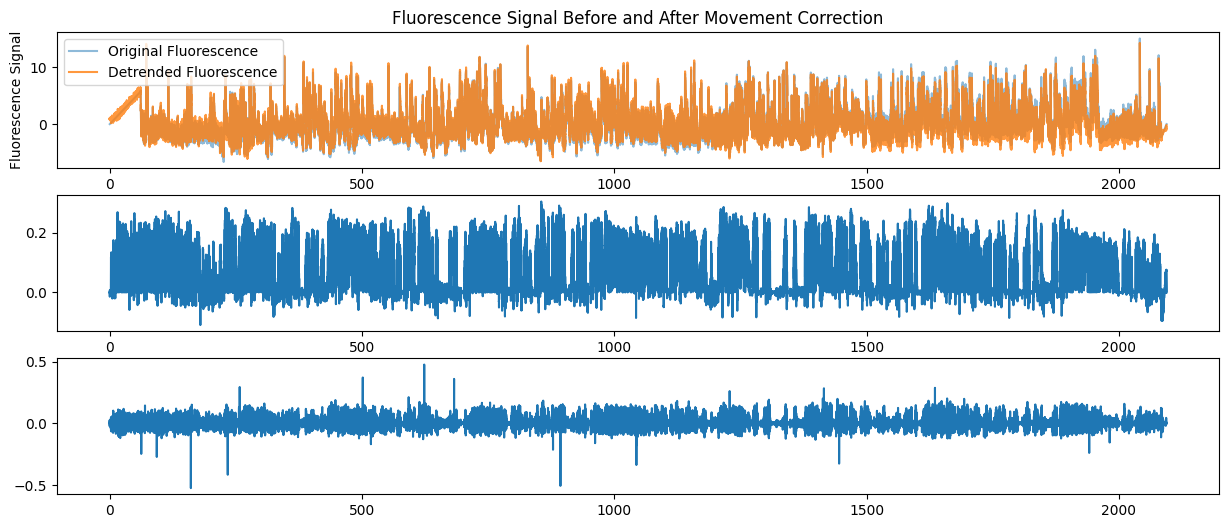

In [144]:
subset = filter_data(GCaMP_MM_1, ['B3M3', 'day1'])

detrended_data = correlation_remove(subset, fluorescence="470_dfF", movement=["movementX", "movementY"], chunk_size=300000)


In [ ]:
p

In [109]:
subset

470_dfF  movementX  movementY   halt ExperimentEvents  \
Seconds                                                            
0.000    -0.000003   0.015121   0.003040  False              NaN   
0.001    -0.000010   0.048723   0.009795  False              NaN   
0.002    -0.000016   0.082325   0.016550  False              NaN   
0.003    -0.000023   0.115569   0.023246  False              NaN   
0.004    -0.000029   0.126261   0.026171  False              NaN   
...            ...        ...        ...    ...              ...   
2124.006  0.001038   0.000000   0.000000  False              NaN   
2124.007  0.000746   0.000000   0.000000  False              NaN   
2124.008  0.000453   0.000000   0.000000  False              NaN   
2124.009  0.000161   0.000000   0.000000  False              NaN   
2124.010  0.000000   0.000000   0.000000  False              NaN   

                 Experiment Session mouseID sex area  No_halt  \
Seconds                                                         
0.000     MMclosed-and-open    day1    B3M2   M  V2M    False   
0.001     MMclosed-and-open    day1    B3M2   M  V2M    False   
0.002     MMclosed-and-open    day1    B3M2   M  V2M    False   
0.003     MMclosed-and-open    day1    B3M2   M  V2M    False   
0.004     MMclosed-and-open    day1    B3M2   M  V2M    False   
...                     ...     ...     ...  ..  ...      ...   
2124.006  MMclosed-and-open    day1    B3M2   M  V2M    False   
2124.007  MMclosed-and-open    day1    B3M2   M  V2M    False   
2124.008  MMclosed-and-open    day1    B3M2   M  V2M    False   
2124.009  MMclosed-and-open    day1    B3M2   M  V2M    False   
2124.010  MMclosed-and-open    day1    B3M2   M  V2M    False   

          LinearMismatch_block  LinearPlaybackMismatch_block  
Seconds                                                       
0.000                    False                         False  
0.001                    False                         False  
0.002                    False                         False  
0.003                    False                         False  
0.004                    False                         False  
...                        ...                           ...  
2124.006                 False                         False  
2124.007                 False                         False  
2124.008                 False                         False  
2124.009                 False                         False  
2124.010                 False                         False  

[2124011 rows x 13 columns]